In [1]:
%load_ext autoreload
%autoreload 2

from pandas_profiling import ProfileReport
%pylab inline

import warnings
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [4]:
df_train = pd.read_csv('./data/train_2016_v2.csv')

In [5]:
dtypes = {
    'parcelid': int,
    'airconditioningtypeid': str,
    'architecturalstyletypeid': str,
    'buildingclasstypeid': str,
    'buildingqualitytypeid': str,
    'decktypeid': str,
    'heatingorsystemtypeid': str,
    'pooltypeid10': str,
    'pooltypeid2': str,
    'pooltypeid7': str,
    'regionidcity': str,
    'regionidcounty': str,
    'regionidneighborhood': str,
    'regionidzip': str,
    'typeconstructiontypeid': str,
    'hashottuborspa': str,
    'propertycountylandusecode': str,
    'propertylandusetypeid': str,
    'propertyzoningdesc': str,
    'rawcensustractandblock': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str,
    'censustractandblock': str,
}

props_df = pd.read_csv('./data/properties_2016.csv', dtype=dtypes)

dtypes.update({
    'fireplacecnt': int,
    'fullbathcnt': int,
    'garagecarcnt': int,
    'poolcnt': int,
    'threequarterbathnbr': int,
    'unitcnt': int,
    'yearbuilt': int,
    'numberofstories': int,
    'structuretaxvaluedollarcnt': int,
    'taxvaluedollarcnt': int,
    'landtaxvaluedollarcnt': int,
    'taxdelinquencyyear': int,
    'roomcnt': int,
    'bedroomcnt': int,
    'assessmentyear': int,
    'fips': int,
})

In [6]:
df_train = df_train.merge(props_df, on='parcelid', how='left')
df_train.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,NaN,NaN,2.0,3.0,NaN,4,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,60371066461001
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,NaN,NaN,3.0,2.0,NaN,4,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,60374638003004
3,12643413,0.0218,2016-01-02,1,NaN,NaN,2.0,2.0,NaN,4,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,60372963002002
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,60590423381006


In [25]:
def log_transf(df):
    if 'structuretaxvaluedollarcnt' in df.columns:
        df.loc[:, 'structuretaxvaluedollarcnt'] = np.log1p(df.structuretaxvaluedollarcnt).copy()
    if 'taxvaluedollarcnt' in df.columns:
        df.loc[:, 'taxvaluedollarcnt'] = np.log1p(df.taxvaluedollarcnt).copy()
    if 'calculatedfinishedsquarefeet' in df.columns:
        df.loc[:, 'calculatedfinishedsquarefeet'] = np.log1p(df.calculatedfinishedsquarefeet).copy()
    if 'lotsizesquarefeet' in df.columns:
        df.loc[:, 'lotsizesquarefeet'] = np.log1p(df.lotsizesquarefeet).copy()
    if 'finishedsquarefeet12' in df.columns:
        df.loc[:, 'finishedsquarefeet12'] = np.log1p(df.finishedsquarefeet12).copy()
    return df


def preprocess(df, rejected_cols=[], l_perc=1, u_perc=99, l_perc_val=None, u_perc_val=None,
               month_agg=None):
    drop_cols = set(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc',
                     'propertycountylandusecode']+rejected_cols)
    df = df.copy()
    df['latitude'] = df.latitude / 1e6
    df['longitude'] = df.longitude / 1e6
    if 'transactiondate' in df.columns and month_agg is None:
        df['transactiondate'] = pd.to_datetime(df.transactiondate)
        df['transactionmonth'] = df.transactiondate.dt.month
        month_agg = df[['transactionmonth', 'logerror']].groupby('transactionmonth').mean()
        for m, v in month_agg.iterrows():
            df.loc[df.transactionmonth == m, 'transactionmonthavglogerr'] = v.logerror
    else:
        df['transactionmonth'] = month_agg[0]
        df['transactionmonthavglogerr'] = month_agg[1]
    
    # From https://www.kaggle.com/nikunjm88/creating-additional-features
    #life of property
    df['N-life'] = 2018 - df['yearbuilt']

    #proportion of living area
    df['N-LivingAreaProp'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']
    df['N-LivingAreaProp2'] = df['N-LivingAreaProp']**2
    df['N-LivingAreaProp3'] = df['N-LivingAreaProp']**3
    df['N-LivingAreaProp-2'] = df['finishedsquarefeet12']/df['finishedsquarefeet15']

    #Amout of extra space
    df['N-ExtraSpace'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
    df['N-ExtraSpace-2'] = df['finishedsquarefeet15'] - df['finishedsquarefeet12'] 

    #Total number of rooms
    df['N-TotalRooms'] = df['bathroomcnt']*df['bedroomcnt']

    #Average room size
    df['N-AvRoomSize'] = df['calculatedfinishedsquarefeet']/df['roomcnt'] 

    # Number of Extra rooms
    df['N-ExtraRooms'] = df['roomcnt'] - df['N-TotalRooms'] 

    #Ratio of the built structure value to land area
    df['N-ValueProp'] = df['structuretaxvaluedollarcnt']/df['landtaxvaluedollarcnt']

    df['N-ValueProp2'] = df['N-ValueProp']**2
    df['N-ValueProp3'] = df['N-ValueProp']**3
    
    #Does property have a garage, pool or hot tub and AC?
    df['N-GarPoolAC'] = ((df['garagecarcnt'] > 0) &
                         (df['pooltypeid10'] != '0') &
                         (df['airconditioningtypeid'] != '5'))*1 
    drop_cols.add('garagecarcnt')
    
    df["N-location"] = df["latitude"] + df["longitude"]
    df["N-location-2"] = df["latitude"] * df["longitude"]
    df["N-location-2round"] = df["N-location-2"].round(-4)

    df["N-latitude-round"] = df["latitude"].round(-4)
    df["N-longitude-round"] = df["longitude"].round(-4)

    #Ratio of tax of property over parcel
    df['N-ValueRatio'] = df['taxvaluedollarcnt']/df['taxamount']
    df['N-ValueRatio2'] = df['N-ValueRatio']**2
    df['N-ValueRatio3'] = df['N-ValueRatio']**3

    #TotalTaxScore
    df['N-TaxScore'] = df['taxvaluedollarcnt']*df['taxamount']
    df['N-TaxScore2'] = df['N-TaxScore']**2
    df['N-TaxScore3'] = df['N-TaxScore']**3
    
    #polnomials of tax delinquency year
    df["N-taxdelinquencyyear-2"] = df["taxdelinquencyyear"] ** 2
    df["N-taxdelinquencyyear-3"] = df["taxdelinquencyyear"] ** 3

    #Length of time since unpaid taxes
    df['N-life'] = 2018 - df['taxdelinquencyyear']

    #Number of properties in the zip
    zip_count = df['regionidzip'].value_counts().to_dict()
    df['N-zip_count'] = df['regionidzip'].map(zip_count)

    #Number of properties in the city
    city_count = df['regionidcity'].value_counts().to_dict()
    df['N-city_count'] = df['regionidcity'].map(city_count)

    #Number of properties in the city
    region_count = df['regionidcounty'].value_counts().to_dict()
    df['N-county_count'] = df['regionidcounty'].map(city_count)

    #Indicator whether it has AC or not
    df['N-ACInd'] = (df['airconditioningtypeid']!=5)*1

    #Indicator whether it has Heating or not 
    df['N-HeatInd'] = (df['heatingorsystemtypeid']!=13)*1

    #There's 25 different property uses - let's compress them down to 4 categories
    df['N-PropType'] = df.propertylandusetypeid.replace({
        31 : "Mixed",
        46 : "Other",
        47 : "Mixed",
        246 : "Mixed",
        247 : "Mixed",
        248 : "Mixed",
        260 : "Home",
        261 : "Home",
        262 : "Home",
        263 : "Home",
        264 : "Home",
        265 : "Home",
        266 : "Home",
        267 : "Home",
        268 : "Home",
        269 : "Not Built",
        270 : "Home",
        271 : "Home",
        273 : "Home",
        274 : "Other",
        275 : "Home",
        276 : "Home",
        279 : "Home",
        290 : "Not Built",
        291 : "Not Built"
    })
    drop_cols.add('propertylandusetypeid')


    #polnomials of the variable
    df["N-structuretaxvaluedollarcnt-2"] = df["structuretaxvaluedollarcnt"] ** 2
    df["N-structuretaxvaluedollarcnt-3"] = df["structuretaxvaluedollarcnt"] ** 3

    #Average structuretaxvaluedollarcnt by city
    group = df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    df['N-Avg-structuretaxvaluedollarcnt'] = df['regionidcity'].map(group)

    #Deviation away from average
    df['N-Dev-structuretaxvaluedollarcnt'] = (abs((df['structuretaxvaluedollarcnt'] -
                                                   df['N-Avg-structuretaxvaluedollarcnt'])) /
                                              df['N-Avg-structuretaxvaluedollarcnt'])

    df['fireplaceflag'] = df.fireplaceflag == 'True'
    df['taxdelinquencyflag'] = df.taxdelinquencyflag == 'Y'
    df['hashottuborspa'] = df.hashottuborspa == 'true'

    df['fireplacecnt'] = df.fireplacecnt.fillna(0).astype(int)
    df['fullbathcnt'] = df.fullbathcnt.fillna(0).astype(int)
    df['garagecarcnt'] = df.garagecarcnt.fillna(0).astype(int)
    df['poolcnt'] = df.poolcnt.fillna(0).astype(int)
    df['threequarterbathnbr'] = df.threequarterbathnbr.fillna(0).astype(int)
    df['unitcnt'] = df.threequarterbathnbr.fillna(0).astype(int)
    df['numberofstories'] = df.numberofstories.fillna(0).astype(int)
    df['numberofstories'] = df.numberofstories.fillna(0).astype(int)
    df['roomcnt'] = df.roomcnt.fillna(0).astype(int)
    df['bedroomcnt'] = df.bedroomcnt.fillna(0).astype(int)
    df['bedroomcnt'] = df.bedroomcnt.fillna(0).astype(int)

    df['fips'] = df.fips.fillna(-1).astype(int)

    df['yearbuilt'] = df.yearbuilt.fillna(np.round(df.yearbuilt.mean())).astype(int)
    df['taxdelinquencyyear'] = df.taxdelinquencyyear.fillna(
        np.round(df.taxdelinquencyyear.mean())
    ).astype(int)
    df['assessmentyear'] = df.assessmentyear.fillna(
        np.round(df.assessmentyear.mean())
    ).astype(int)
    df['structuretaxvaluedollarcnt'] = df.structuretaxvaluedollarcnt.fillna(
        np.round(df.structuretaxvaluedollarcnt.mean())
    ).astype(int)
    df['taxvaluedollarcnt'] = df.taxvaluedollarcnt.fillna(
        np.round(df.taxvaluedollarcnt.mean())
    ).astype(int)
    df['landtaxvaluedollarcnt'] = df.landtaxvaluedollarcnt.fillna(
        np.round(df.landtaxvaluedollarcnt.mean())
    ).astype(int)
    
    # drop columns with std 0
    df = df.drop(['buildingclasstypeid', 'pooltypeid10', 'pooltypeid7',
                  'storytypeid', 'poolcnt', 'assessmentyear'], axis=1, errors='ignore')

    df_cols = df.columns
    df.loc[:, df_cols.str.contains('sqft')] = df.loc[:, df_cols.str.contains('sqft')].fillna(0)
    
    # set nan values in *squarefeet* columns to 0
    df.loc[:, df_cols.str.contains('squarefeet')] = df.loc[:, df_cols.str.contains('squarefeet')].fillna(0)

    
    # fill NaNs in *typeid* columns to -1
    df.loc[:, df_cols.str.contains('typeid')] = df.loc[:, df_cols.str.contains('typeid')].fillna(-1)
    
    # set nan values in *cnt* columns to 0
    df.loc[:, df_cols.str.contains('cnt')] = df.loc[:, df_cols.str.contains('cnt')].fillna(0)
    
    # set NaNs in rest of counts/sums columns to 0
    cols = ['calculatedbathnbr', 'poolsizesum', 'threequarterbathnbr', 'numberofstories']
    df.loc[:, cols] = df.loc[:, cols].fillna(0)

    # set NaNs in rest of id/code columns to 0
    cols = ['regionidcity', 'regionidneighborhood', 'regionidzip', 'censustractandblock']
    df.loc[:, cols] = df.loc[:, cols].fillna(-1)

    # set NaNs in rest of dates columns to mean
    cols = ['yearbuilt', 'taxamount', 'taxdelinquencyyear']
    df.loc[:, cols] = df.loc[:, cols].fillna(df.loc[:, cols].mean())

    drop_cols &= set(df.columns)
    X = df.drop(drop_cols, axis=1).copy()
    y = None
    if 'logerror' in df.columns:
        y = df['logerror'].values.copy()
        if l_perc_val is None and u_perc_val is None:
            l_perc_val, u_perc_val = np.percentile(y, [l_perc, u_perc])
        elif l_perc_val is None:
            l_perc_val, u_perc_val = np.percentile(y, l_perc)
        elif u_perc_val is None:
            u_perc_val = np.percentile(y, u_perc)
        mask = (y > l_perc_val) & (y < u_perc_val)
        y = y[mask]

    for c in X.columns:
        if X[c].dtype == 'object':
            lbl = LabelEncoder()
            X[c] = lbl.fit_transform(list(X[c].values))

    X = log_transf(X)
    X['calculatedfinishedsquarefeet2'] = X['calculatedfinishedsquarefeet']**2
    X['calculatedfinishedsquarefeet3'] = X['calculatedfinishedsquarefeet']**3
    
    if y is not None:
        X = X.loc[mask]
    
    return X, y, l_perc_val, u_perc_val, month_agg

In [7]:
df_train1, df_test =\
    train_test_split(df_train, test_size=0.2, random_state=0, stratify=np.sign(df_train.logerror))

In [30]:
month_agg.values

array([[ 0.01578131],
       [ 0.01544458],
       [ 0.01091694],
       [ 0.00520398],
       [ 0.00653953],
       [ 0.00834217],
       [ 0.01165187],
       [ 0.01007382],
       [ 0.01688548],
       [ 0.01773985],
       [ 0.01612922],
       [ 0.02328138]])

In [39]:
rejected_cols1 = [
    'calculatedbathnbr',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'finishedsquarefeet6',
    'fullbathcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
]
X_train, y_train, l_perc_val, u_perc_val, month_agg = preprocess(df_train1, rejected_cols1)
X_test = []
y_test = []
test_transactiondates = pd.to_datetime(df_test.transactiondate)
for m, v in month_agg.iterrows():
    xx, yy, *_ = preprocess(df_test[test_transactiondates.dt.month == m],
                            rejected_cols1, month_agg=(m, v.logerror))
    X_test.append(xx)
    y_test.append(yy)

X_test = pd.concat(X_test)
y_test = np.hstack(y_test)

In [40]:
rejected_cols2 = [
    'censustractandblock',
    'typeconstructiontypeid',
    'unitcnt'
]
X_train = X_train.drop(rejected_cols2, axis=1)
X_test = X_test.drop(rejected_cols2, axis=1)

In [41]:
sk_params = {
    'boosting_type': 'dart',
    'colsample_bytree': 1,
    'learning_rate': 0.03,
    'max_bin': 500,
    'n_estimators': 300,
    'nthread': -1,
    'num_leaves': 100,
    'objective': 'regression_l1',
    'seed ': 0,
    'silent': False,
    'subsample': 1
}

model = lgb.sklearn.LGBMRegressor(**sk_params)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='dart', colsample_bytree=1, learning_rate=0.03,
       max_bin=500, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0, n_estimators=300, nthread=-1, num_leaves=100,
       objective='regression_l1', reg_alpha=0, reg_lambda=0, seed=0,
       seed =0, silent=False, subsample=1, subsample_for_bin=50000,
       subsample_freq=1)

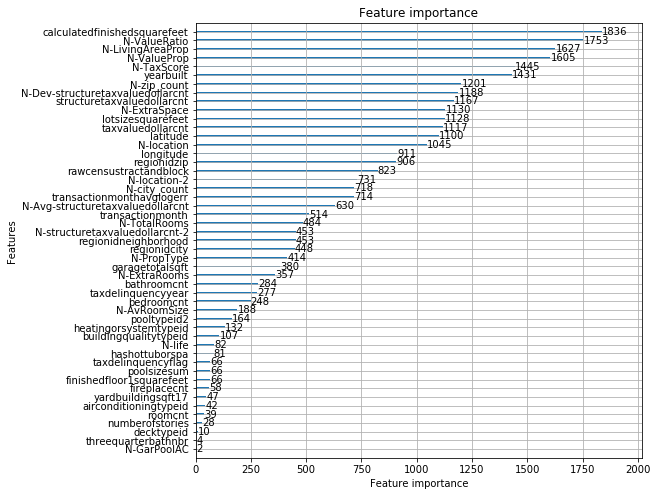

In [42]:
ax = plt.figure(figsize=(8, 8)).gca()
lgb.plotting.plot_importance(model, ax=ax)

# Hyperparam optimization

In [43]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform as sp_uniform, randint as sp_randint

param_space = {
    'boosting_type': ['dart'],
    'num_leaves': sp_randint(90, 200),
    'learning_rate': sp_uniform(0.02, 0.2),
    'n_estimators': sp_randint(200, 500),
    'objective': ['regression_l1'],
    'subsample': sp_uniform(0.8, 0.2),
    'colsample_bytree': sp_uniform(0.9, 0.1),
    'nthread': [-1],
    'silent': [False],
    'seed ' : [0],
    'max_bin': [500],
    
}


rs = RandomizedSearchCV(lgb.sklearn.LGBMRegressor(), param_space, n_jobs=1,
                        verbose=2, random_state=0, scoring='neg_mean_absolute_error',
                        n_iter=20, cv=5)

rs.fit(X_train, y_train)

display(rs.best_score_)
rs.best_params_

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757 
[CV]  boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757, total=  30.2s
[CV] boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   31.1s remaining:    0.0s


[CV]  boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757, total=  29.8s
[CV] boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757 
[CV]  boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757, total=  29.0s
[CV] boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.163037873274, max_bin=500, n_estimators=451, nthread=-1, num_leaves=157, objective=regression_l1, seed =0, silent=False, subsample=0.969450347757 
[CV]  boosting_type=dart, colsample_bytree=0.954881350393, learning_rate=0.16303787327

[CV]  boosting_type=dart, colsample_bytree=0.93927847961, learning_rate=0.187215752707, max_bin=500, n_estimators=272, nthread=-1, num_leaves=99, objective=regression_l1, seed =0, silent=False, subsample=0.92963437441, total=  10.4s
[CV] boosting_type=dart, colsample_bytree=0.936824153984, learning_rate=0.211431031791, max_bin=500, n_estimators=299, nthread=-1, num_leaves=178, objective=regression_l1, seed =0, silent=False, subsample=0.960182150396 
[CV]  boosting_type=dart, colsample_bytree=0.936824153984, learning_rate=0.211431031791, max_bin=500, n_estimators=299, nthread=-1, num_leaves=178, objective=regression_l1, seed =0, silent=False, subsample=0.960182150396, total=  23.3s
[CV] boosting_type=dart, colsample_bytree=0.936824153984, learning_rate=0.211431031791, max_bin=500, n_estimators=299, nthread=-1, num_leaves=178, objective=regression_l1, seed =0, silent=False, subsample=0.960182150396 
[CV]  boosting_type=dart, colsample_bytree=0.936824153984, learning_rate=0.211431031791, 

[CV]  boosting_type=dart, colsample_bytree=0.977423368943, learning_rate=0.111230066443, max_bin=500, n_estimators=490, nthread=-1, num_leaves=90, objective=regression_l1, seed =0, silent=False, subsample=0.803757960087, total=  28.0s
[CV] boosting_type=dart, colsample_bytree=0.977423368943, learning_rate=0.111230066443, max_bin=500, n_estimators=490, nthread=-1, num_leaves=90, objective=regression_l1, seed =0, silent=False, subsample=0.803757960087 
[CV]  boosting_type=dart, colsample_bytree=0.977423368943, learning_rate=0.111230066443, max_bin=500, n_estimators=490, nthread=-1, num_leaves=90, objective=regression_l1, seed =0, silent=False, subsample=0.803757960087, total=  28.1s
[CV] boosting_type=dart, colsample_bytree=0.977423368943, learning_rate=0.111230066443, max_bin=500, n_estimators=490, nthread=-1, num_leaves=90, objective=regression_l1, seed =0, silent=False, subsample=0.803757960087 
[CV]  boosting_type=dart, colsample_bytree=0.977423368943, learning_rate=0.111230066443, m

[CV]  boosting_type=dart, colsample_bytree=0.975068614122, learning_rate=0.141566133743, max_bin=500, n_estimators=321, nthread=-1, num_leaves=132, objective=regression_l1, seed =0, silent=False, subsample=0.887720302692, total=  16.4s
[CV] boosting_type=dart, colsample_bytree=0.975068614122, learning_rate=0.141566133743, max_bin=500, n_estimators=321, nthread=-1, num_leaves=132, objective=regression_l1, seed =0, silent=False, subsample=0.887720302692 
[CV]  boosting_type=dart, colsample_bytree=0.975068614122, learning_rate=0.141566133743, max_bin=500, n_estimators=321, nthread=-1, num_leaves=132, objective=regression_l1, seed =0, silent=False, subsample=0.887720302692, total=  15.9s
[CV] boosting_type=dart, colsample_bytree=0.975068614122, learning_rate=0.141566133743, max_bin=500, n_estimators=321, nthread=-1, num_leaves=132, objective=regression_l1, seed =0, silent=False, subsample=0.887720302692 
[CV]  boosting_type=dart, colsample_bytree=0.975068614122, learning_rate=0.14156613374

[CV]  boosting_type=dart, colsample_bytree=0.933800761484, learning_rate=0.154950464452, max_bin=500, n_estimators=248, nthread=-1, num_leaves=139, objective=regression_l1, seed =0, silent=False, subsample=0.955669096405, total=  17.8s
[CV] boosting_type=dart, colsample_bytree=0.933800761484, learning_rate=0.154950464452, max_bin=500, n_estimators=248, nthread=-1, num_leaves=139, objective=regression_l1, seed =0, silent=False, subsample=0.955669096405 
[CV]  boosting_type=dart, colsample_bytree=0.933800761484, learning_rate=0.154950464452, max_bin=500, n_estimators=248, nthread=-1, num_leaves=139, objective=regression_l1, seed =0, silent=False, subsample=0.955669096405, total=  17.4s
[CV] boosting_type=dart, colsample_bytree=0.994957105345, learning_rate=0.15250537339, max_bin=500, n_estimators=294, nthread=-1, num_leaves=90, objective=regression_l1, seed =0, silent=False, subsample=0.924569219109 
[CV]  boosting_type=dart, colsample_bytree=0.994957105345, learning_rate=0.15250537339, 

[CV]  boosting_type=dart, colsample_bytree=0.912019656121, learning_rate=0.0792280395044, max_bin=500, n_estimators=330, nthread=-1, num_leaves=188, objective=regression_l1, seed =0, silent=False, subsample=0.976095177851, total=  23.5s
[CV] boosting_type=dart, colsample_bytree=0.912019656121, learning_rate=0.0792280395044, max_bin=500, n_estimators=330, nthread=-1, num_leaves=188, objective=regression_l1, seed =0, silent=False, subsample=0.976095177851 
[CV]  boosting_type=dart, colsample_bytree=0.912019656121, learning_rate=0.0792280395044, max_bin=500, n_estimators=330, nthread=-1, num_leaves=188, objective=regression_l1, seed =0, silent=False, subsample=0.976095177851, total=  25.3s
[CV] boosting_type=dart, colsample_bytree=0.912019656121, learning_rate=0.0792280395044, max_bin=500, n_estimators=330, nthread=-1, num_leaves=188, objective=regression_l1, seed =0, silent=False, subsample=0.976095177851 
[CV]  boosting_type=dart, colsample_bytree=0.912019656121, learning_rate=0.0792280

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 37.9min finished


-0.052283366003951816

{'boosting_type': 'dart',
 'colsample_bytree': 0.99883738380592269,
 'learning_rate': 0.040408962149605612,
 'max_bin': 500,
 'n_estimators': 327,
 'nthread': -1,
 'num_leaves': 93,
 'objective': 'regression_l1',
 'seed ': 0,
 'silent': False,
 'subsample': 0.99905991353557755}

In [44]:
dtrain2 = lgb.Dataset(X_train, label=y_train)

params = {
    'boosting_type': 'dart',
    'colsample_bytree': 0.99883738380592269,
    'learning_rate': 0.040408962149605612,
    'max_bin': 500,
#     'n_estimators': 327,
    'nthread': -1,
    'num_leaves': 93,
    'objective': 'regression_l1',
    'seed ': 0,
#     'silent': False,
    'subsample': 0.99905991353557755
}

hist = lgb.cv(params=params, train_set=dtrain2, metrics='mae', num_boost_round=1000, early_stopping_rounds=100)
hist

/home/mtambos/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'l1-mean': [0.052975616553517901,
  0.052929230066178265,
  0.052886414361944654,
  0.052847712966655136,
  0.052811588498070036,
  0.052779016628197492,
  0.052748664667659408,
  0.052762446727394371,
  0.052735254198982826,
  0.052708410717770326,
  0.052683003011044408,
  0.05269179475456516,
  0.052669056539825655,
  0.052645528849764256,
  0.052624542410007621,
  0.052606416011964585,
  0.052585072492229587,
  0.052565417622733146,
  0.052547977834199053,
  0.052530268868819383,
  0.052534922249834914,
  0.052520108762913263,
  0.052505504534883465,
  0.052491127803250992,
  0.052473530819135042,
  0.052464365032169037,
  0.052450962921254195,
  0.052457371860633165,
  0.052446109065813519,
  0.05243759693860954,
  0.052439022795073495,
  0.052428702663559278,
  0.052417096540569384,
  0.052403960168010688,
  0.05240767310994239,
  0.05241601691719109,
  0.052407095409448545,
  0.052397530888805458,
  0.052388302644882388,
  0.052392182862038984,
  0.052398767790139487,
  0.05238

In [45]:
sk_params = {
    'boosting_type': 'dart',
    'colsample_bytree': 0.99883738380592269,
    'learning_rate': 0.040408962149605612,
    'max_bin': 500,
    'n_estimators': 327,
    'nthread': -1,
    'num_leaves': 93,
    'objective': 'regression_l1',
    'seed ': 0,
    'silent': False,
    'subsample': 0.99905991353557755
}

cv_score = cross_val_score(lgb.sklearn.LGBMRegressor(**sk_params), X_train, y_train,
                           cv=10, scoring='neg_mean_absolute_error', verbose=1)
cv_score.mean(), cv_score.std()*2

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  2.8min finished


(-0.052264357768842695, 0.0010737548403856121)

In [47]:
mean_absolute_error(y_test, rs.best_estimator_.predict(X_test))

0.058646630702640264

# Submission

In [52]:
subm_df = pd.read_csv('./data/sample_submission.csv')
subm_df.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0,0,0,0,0,0
1,10759547,0,0,0,0,0,0
2,10843547,0,0,0,0,0,0
3,10859147,0,0,0,0,0,0
4,10879947,0,0,0,0,0,0


In [48]:
X, y, *_, month_agg = preprocess(df_train, rejected_cols1 + rejected_cols2)

model = lgb.sklearn.LGBMRegressor(**sk_params)
model.fit(X, y)

LGBMRegressor(boosting_type='dart', colsample_bytree=0.9988373838059227,
       learning_rate=0.04040896214960561, max_bin=500, max_depth=-1,
       min_child_samples=10, min_child_weight=5, min_split_gain=0,
       n_estimators=327, nthread=-1, num_leaves=93,
       objective='regression_l1', reg_alpha=0, reg_lambda=0, seed=0,
       seed =0, silent=False, subsample=0.9990599135355775,
       subsample_for_bin=50000, subsample_freq=1)

In [71]:
import gc
gc.collect()

0

In [73]:
from tqdm import tqdm_notebook as tqdmn

test_df = props_df.loc[props_df.parcelid.isin(subm_df.ParcelId)]

for m in tqdmn(subm_df.columns[1:]):
    m_nr = int(m[-2:])
    m_lerr = month_agg.loc[m_nr].logerror
    xx, *_ = preprocess(test_df, rejected_cols1+rejected_cols2,
                        month_agg=(m_nr, m_lerr))
    gc.collect()
    subm_df[m] = model.predict(xx)
subm_df

A Jupyter Widget

TypeError: 'int' object is not subscriptable

In [77]:
subm_df = subm_df.drop([10, 11], axis=1)
subm_df

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.041009,0.040290,0.040636,0.041009,0.040290,0.040636
1,10759547,0.015692,0.015001,0.015320,0.015692,0.015001,0.015320
2,10843547,0.056378,0.052826,0.056378,0.056378,0.052826,0.056378
3,10859147,0.027225,0.024866,0.027225,0.027225,0.024866,0.027225
4,10879947,0.012353,0.012431,0.012353,0.012353,0.012431,0.012353
5,10898347,0.046758,0.046831,0.046758,0.046758,0.046831,0.046758
6,10933547,0.020817,0.020870,0.020817,0.020817,0.020870,0.020817
7,10940747,0.035597,0.035945,0.035597,0.035597,0.035945,0.035597
8,10954547,0.013484,0.013613,0.014082,0.013484,0.013613,0.014082
9,10976347,0.015641,0.015695,0.015641,0.015641,0.015695,0.015641


In [78]:
subm_df.to_csv('lgbm_no_out_monthly.csv', index=False, float_format='%.4f')